In [3]:
# Librerías que usamos
import numpy as np 
import pandas as pd 
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt 
from scipy.optimize import differential_evolution
from scipy.optimize import NonlinearConstraint, LinearConstraint, Bounds

### Modelo a ajustar aquí 

Solo patada en los medios:

$$ \dot n = - p n + \alpha o_{\tau} $$

$$ \dot o = -q o + r n + k o o_{\tau}$$

donde $o_{\tau} = o(t - \tau)$ que puede ser reemplazada por un conjunto finito de ecuaciones diferenciales ordinarias que simulen una distribución de delays.


In [4]:
def integrate_model(args, tmax, x0):
    
    p, alpha, q, r, k, tau = args
    tt = np.arange(0, tmax, 0.01)
         
    def model(x, t, p, alpha, q, r, k, tau):
         
            n = len(x)
            fs = np.zeros(n)
            
            fs[0] = - p * x[0] + alpha * x[-1]
            fs[1] = - q * x[1] + r * x[0] + k * x[1] * x[-1]
            for i in range(2, n):
                fs[i] = ((n-2)/tau) * (x[i-1] - x[i])
    
            return fs
        
    # Integración numérica del modelo 
    yint = odeint(model, x0, tt, args=(p, alpha, q, r, k, tau), full_output=0)

    return tt, yint        

### Initial guess

In [31]:
# Fileid of the series to analyze
fileid = 1049654

In [32]:
filename = f'../Extraccion_datos_leskovec/Series_a_ajustar/Corte_id{fileid}.csv'

data = pd.read_csv(filename, parse_dates=[0])
data.set_index('time', inplace=True)
data.media = data.media.div(data.media.max())
data.blog = data.blog.div(data.blog.max())

# Cambiar acá si queremos ajustar solo una parte de los datos
init_index = data.media.argmax()
data = data[init_index:init_index + 168]

In [33]:
# Start parameters: ['p', 'alpha', 'q', 'r', 'k', 'tau']
start_params = [0.1, 0.1, 0.3, 0.3, 0.00, 60]

# Figures
ngammas = 30
coeffs = start_params
x0 = [1.00, 1.00] + [0.00] * ngammas

tt, yy = integrate_model(coeffs, data.shape[0], x0)

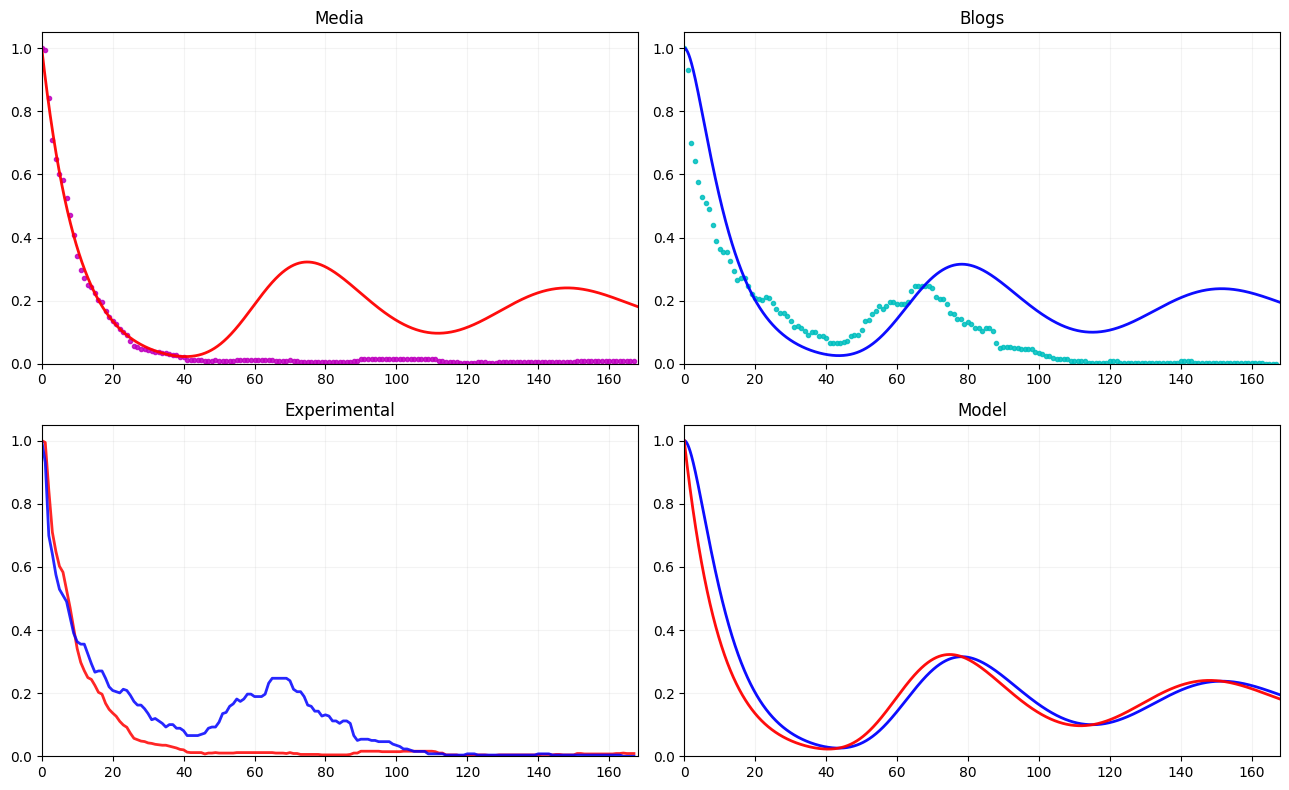

In [34]:
fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize = (13,8), dpi = 100)
ax.plot(data.media.to_numpy(), '.', color = 'm', linewidth = 2, label = 'media', alpha = 0.85)
ax.plot(tt, yy[:,0], color = 'red',  linestyle = '-', linewidth = 2, alpha = 0.95)
ax.set_ylim([0.00, 1.05])
ax.set_xlim([0, data.shape[0]])
ax.grid(True, alpha = 0.15)
ax.set_title('Media')

ax2.plot(data.blog.to_numpy(), '.', color = 'c', linewidth = 2, label = 'blog', alpha = 0.85)
ax2.plot(tt, yy[:,1], color = 'blue', linewidth = 2, linestyle = '-', alpha = 0.95)
ax2.set_ylim([0.00, 1.05])
ax2.set_xlim([0, data.shape[0]])
ax2.grid(True, alpha = 0.15)
ax2.set_title('Blogs')

ax3.plot(data.media.to_numpy(), '-', color = 'r', linewidth = 2, label = 'media', alpha = 0.85)
ax3.plot(data.blog.to_numpy(), '-', color = 'b', linewidth = 2, label = 'blog', alpha = 0.85)

ax3.set_ylim([0.00, 1.05])
ax3.set_xlim([0, data.shape[0]])
ax3.grid(True, alpha = 0.15)
ax3.set_title('Experimental')

ax4.plot(tt, yy[:,1], color = 'blue', linewidth = 2, linestyle = '-', alpha = 0.95)
ax4.plot(tt, yy[:,0], color = 'red',  linestyle = '-', linewidth = 2, alpha = 0.95)

ax4.set_ylim([0.00, 1.05])
ax4.set_xlim([0, data.shape[0]])
ax4.grid(True, alpha = 0.15)
ax4.set_title('Model')

fig.tight_layout()


plt.show()

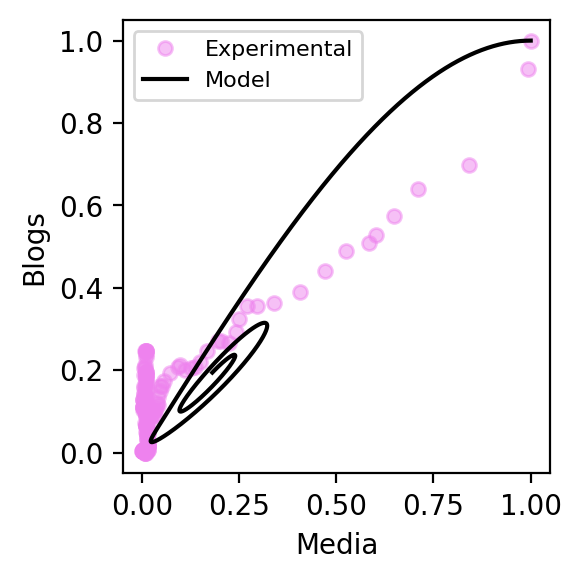

In [35]:
# Phase diagram

plt.figure(figsize = (3,3), dpi = 200)
plt.plot(data.media.to_numpy(), data.blog.to_numpy(), '.', markersize = 10, alpha = 0.50, color = 'violet', label = 'Experimental')
plt.plot(yy[:,0], yy[:,1], color = 'k', label = 'Model')
plt.xlabel('Media')
plt.ylabel('Blogs')
plt.legend(loc = 'best', fontsize = 8)
plt.tight_layout()
plt.show()

### Parameter fitting

In [8]:
def function2minimize(all_coeffs, data, ngammas):
    
    coeffs = all_coeffs[:(len(all_coeffs) - 2)]
    
    x0 = all_coeffs[-2:]
    x0 = list(x0) + [0.00]*ngammas
    
    tt, yy = integrate_model(coeffs, data.shape[0], x0)
    
    media_integrated = yy[tt % 1 == 0][:data.shape[0], 0]
    blog_integrated = yy[tt % 1 == 0][:data.shape[0], 1]
    
    error = (((media_integrated - data.media.to_numpy())**2) + ((blog_integrated - data.blog.to_numpy())**2))**0.5
    
    return np.mean(error)

In [9]:
lims = {'p': [0.001, 1], 
            'alpha': [0.001, 1],
            'q': [0.001, 1], 
            'r': [0.001, 1], 
            'k': [-10.00, 10.00], 
            'tau': [12, data.shape[0]-24],
            'm0': [0.75, 1.25],
            'b0': [0.75*data.blog.iloc[0], 1.25*data.blog.iloc[0]]}

lower_bounds = [l[0] for l in lims.values()]
upper_bounds = [l[1] for l in lims.values()]

bounds = Bounds(lower_bounds, upper_bounds)

In [11]:
popsize = 8
ngammas = 30
sol = differential_evolution(function2minimize, bounds=bounds, args=(data, ngammas), 
                                 popsize=popsize, recombination = 0.30, mutation = (0.1, 1.9),
                                 updating='deferred', workers = 8, tol = 0.001,
                                 polish= False, disp = True, maxiter = 200, x0 = start_params + [1.00, data.blog[0]])

/home/sebastian/.local/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/sebastian/.local/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/sebastian/.local/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/sebastian/.local/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


differential_evolution step 1: f(x)= 0.0913371
differential_evolution step 2: f(x)= 0.0913371
differential_evolution step 3: f(x)= 0.0913371
differential_evolution step 4: f(x)= 0.0913371
differential_evolution step 5: f(x)= 0.0913371
differential_evolution step 6: f(x)= 0.0814357
differential_evolution step 7: f(x)= 0.0814357
differential_evolution step 8: f(x)= 0.0796601
differential_evolution step 9: f(x)= 0.059264
differential_evolution step 10: f(x)= 0.059264
differential_evolution step 11: f(x)= 0.059264
differential_evolution step 12: f(x)= 0.059264
differential_evolution step 13: f(x)= 0.059264
differential_evolution step 14: f(x)= 0.059264
differential_evolution step 15: f(x)= 0.059264
differential_evolution step 16: f(x)= 0.059264
differential_evolution step 17: f(x)= 0.0563075
differential_evolution step 18: f(x)= 0.0563075
differential_evolution step 19: f(x)= 0.0563075


/tmp/ipykernel_7676/3869162648.py:30: RuntimeWarning: overflow encountered in square
  error = (((media_integrated - data.media.to_numpy())**2) + ((blog_integrated - data.blog.to_numpy())**2))**0.5


differential_evolution step 20: f(x)= 0.0563075
differential_evolution step 21: f(x)= 0.0563075
differential_evolution step 22: f(x)= 0.0563075
differential_evolution step 23: f(x)= 0.0563075
differential_evolution step 24: f(x)= 0.0563075
differential_evolution step 25: f(x)= 0.0563075
differential_evolution step 26: f(x)= 0.0563075
differential_evolution step 27: f(x)= 0.0563075
differential_evolution step 28: f(x)= 0.0563075
differential_evolution step 29: f(x)= 0.0563075
differential_evolution step 30: f(x)= 0.0563075
differential_evolution step 31: f(x)= 0.0563075
differential_evolution step 32: f(x)= 0.0563075
differential_evolution step 33: f(x)= 0.0563075
differential_evolution step 34: f(x)= 0.054727
differential_evolution step 35: f(x)= 0.054727
differential_evolution step 36: f(x)= 0.054727
differential_evolution step 37: f(x)= 0.054727
differential_evolution step 38: f(x)= 0.054727
differential_evolution step 39: f(x)= 0.054727
differential_evolution step 40: f(x)= 0.053116

/tmp/ipykernel_7676/3869162648.py:30: RuntimeWarning: overflow encountered in square
  error = (((media_integrated - data.media.to_numpy())**2) + ((blog_integrated - data.blog.to_numpy())**2))**0.5


differential_evolution step 186: f(x)= 0.03656
differential_evolution step 187: f(x)= 0.03656
differential_evolution step 188: f(x)= 0.03656


/tmp/ipykernel_7676/3869162648.py:30: RuntimeWarning: overflow encountered in square
  error = (((media_integrated - data.media.to_numpy())**2) + ((blog_integrated - data.blog.to_numpy())**2))**0.5


differential_evolution step 189: f(x)= 0.03656
differential_evolution step 190: f(x)= 0.03656
differential_evolution step 191: f(x)= 0.03656
differential_evolution step 192: f(x)= 0.03656
differential_evolution step 193: f(x)= 0.03656
differential_evolution step 194: f(x)= 0.03656


/tmp/ipykernel_7676/3869162648.py:30: RuntimeWarning: overflow encountered in square
  error = (((media_integrated - data.media.to_numpy())**2) + ((blog_integrated - data.blog.to_numpy())**2))**0.5


differential_evolution step 195: f(x)= 0.03656
differential_evolution step 196: f(x)= 0.03656
differential_evolution step 197: f(x)= 0.03656
differential_evolution step 198: f(x)= 0.03656
differential_evolution step 199: f(x)= 0.03656
differential_evolution step 200: f(x)= 0.03656


#### Result

In [12]:
# Integration of the model with final parameters
coeffs = sol.x[:len(sol.x)-2]
x0 = list(sol.x[-2:]) + [0.00] * ngammas

tt, yy = integrate_model(coeffs, data.shape[0], x0)

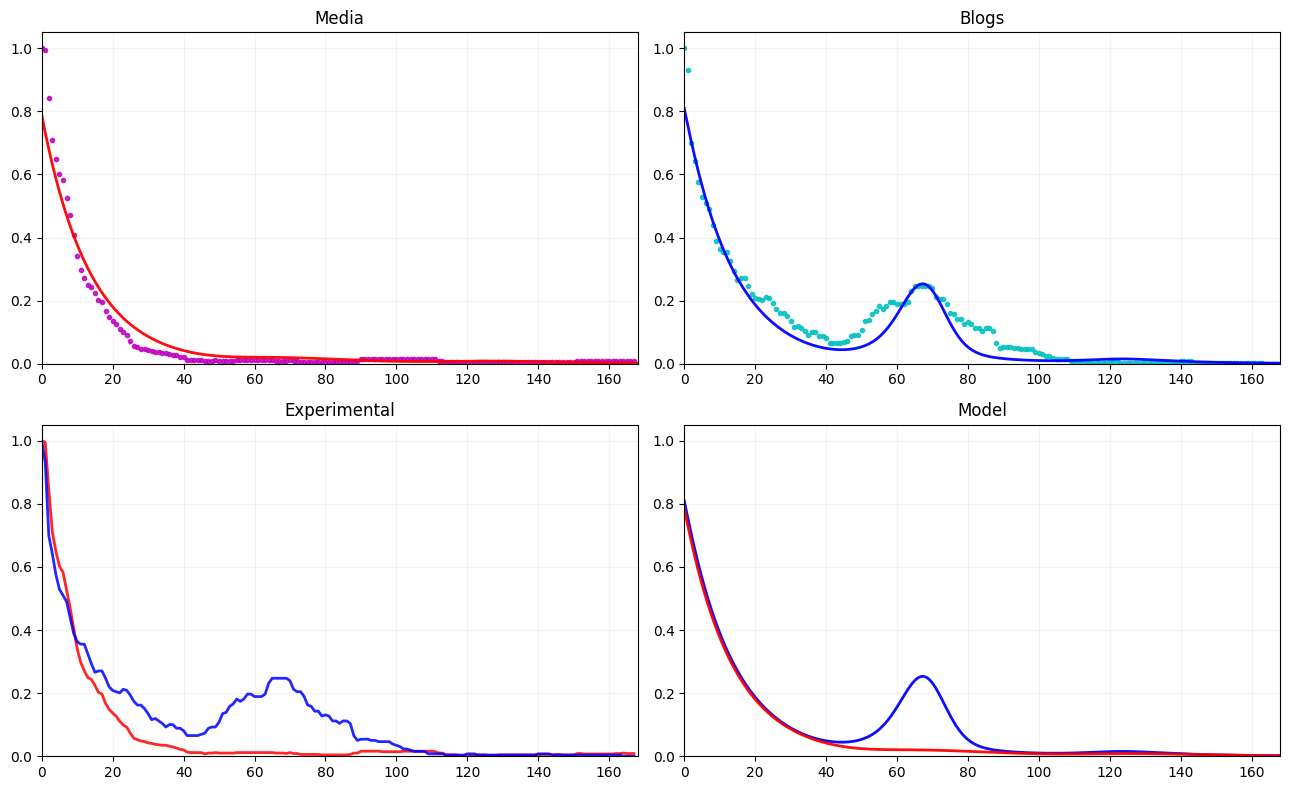

In [17]:
# Figures

fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize = (13,8), dpi = 100)
ax.plot(data.media.to_numpy(), '.', color = 'm', linewidth = 2, label = 'media', alpha = 0.85)
ax.plot(tt, yy[:,0], color = 'red',  linestyle = '-', linewidth = 2, alpha = 0.95)
ax.set_ylim([0.00, 1.05])
ax.set_xlim([0, data.shape[0]])
ax.grid(True, alpha = 0.15)
ax.set_title('Media')

ax2.plot(data.blog.to_numpy(), '.', color = 'c', linewidth = 2, label = 'blog', alpha = 0.85)
ax2.plot(tt, yy[:,1], color = 'blue', linewidth = 2, linestyle = '-', alpha = 0.95)
ax2.set_ylim([0.00, 1.05])
ax2.set_xlim([0, data.shape[0]])
ax2.grid(True, alpha = 0.15)
ax2.set_title('Blogs')

ax3.plot(data.media.to_numpy(), '-', color = 'r', linewidth = 2, label = 'media', alpha = 0.85)
ax3.plot(data.blog.to_numpy(), '-', color = 'b', linewidth = 2, label = 'blog', alpha = 0.85)

ax3.set_ylim([0.00, 1.05])
ax3.set_xlim([0, data.shape[0]])
ax3.grid(True, alpha = 0.15)
ax3.set_title('Experimental')

ax4.plot(tt, yy[:,1], color = 'blue', linewidth = 2, linestyle = '-', alpha = 0.95)
ax4.plot(tt, yy[:,0], color = 'red',  linestyle = '-', linewidth = 2, alpha = 0.95)

ax4.set_ylim([0.00, 1.05])
ax4.set_xlim([0, data.shape[0]])
ax4.grid(True, alpha = 0.15)
ax4.set_title('Model')

fig.tight_layout()

plt.show()

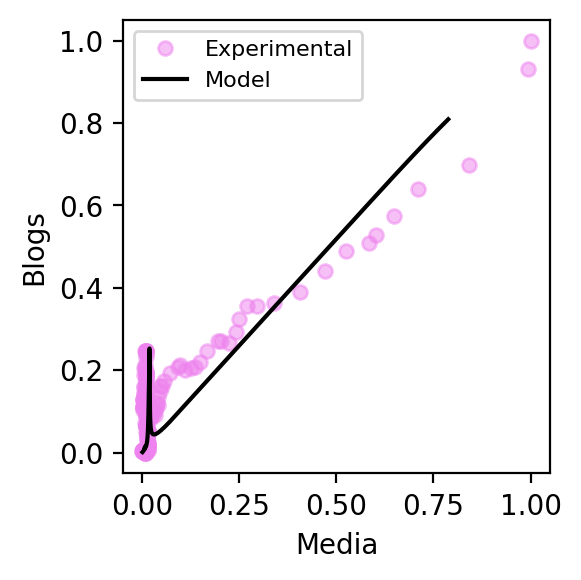

In [30]:
# Phase diagram

plt.figure(figsize = (3,3), dpi = 200)
plt.plot(data.media.to_numpy(), data.blog.to_numpy(), '.', markersize = 10, alpha = 0.50, color = 'violet', label = 'Experimental')
plt.plot(yy[:,0], yy[:,1], color = 'k', label = 'Model')
plt.xlabel('Media')
plt.ylabel('Blogs')
plt.legend(loc = 'best', fontsize = 8)
plt.tight_layout()
plt.show()